# Pulmonary fibrosis

Pulmonary fibrosis is a chronic and progressive lung disease where the air sacs in the lungs, called the alveoli, become scarred and stiff, making it difficult to breathe and get enough oxygen into the bloodstream.

Good read and reference - [here](https://pulmonaryfibrosisnews.com/2019/08/16/twelve-facts-about-pulmonary-fibrosis-prognosis-and-life-expectancy/)

Firstly please upvote if you my work, this will keep me motivated.

## Causes:

1. without known cause (this is called idiopathic pulmonary fibrosis)
2. by exposure to environmental hazards (such as asbestos, coal, silica)
3. by exposure to autoimmune diseases (such as rheumatoid arthritis)
4. caused by medications (such as chemotherapy)
5. In other rare cases, genetics may predispose some patients to develop the disorder.

Our dataset does not help is determining which of the above can be a cause. :(

## Interesting points

1. Older age generally means a worse prognosis
2. Women usually have a better prognosis than men
3. Each year as the disease progresses, pulmonary fibrosis patients will lose an average of between 150 mL and 200 mL of lung capacity, which can be monitored by spirometry

We will see if we can use this information during our experiments. Nice.

Let us also watch a quick video.

In [ ]:
from IPython.display import HTML
HTML('<center><iframe width="560" height="315" src="https://www.youtube.com/embed/cnzOZ1KveMY" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></center>')

# Import libraries 

In [ ]:
import os
import pydicom as dcm
import glob
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import torch
from sklearn.linear_model import Ridge
import random
from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.metrics import mean_squared_error
import category_encoders as ce
from PIL import Image
import cv2
#import pydicom
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
p = sns.color_palette()
import plotly.express as px

# Load CSV files

In [ ]:
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
train['ID'] = train['Patient'].astype(str) + '_' + train['Weeks'].astype(str)
print(train.shape)
train.head()


In [ ]:
test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')

# Examine DICOM count

In [ ]:
patient_sizes = [len(os.listdir('../input/osic-pulmonary-fibrosis-progression/train/' + d)) for d in os.listdir('../input/osic-pulmonary-fibrosis-progression/train/')]
plt.hist(patient_sizes, color=p[2])
plt.ylabel('Number of patients')
plt.xlabel('DICOM files')
plt.title('Histogram of DICOM count per patient');



We have very less patients with more than 200 DICOM files, let us examine if further.

In [ ]:
patient_sizes_arr = np.array(patient_sizes) 
for x in [200,300,400,500,600,800,1000]:
    print("We have ",sum(patient_sizes_arr > x),"patients with more than",x,"DICOM files")

During our experiments - we might have to exclude these 7 patients with huge DICOM files or probably use them differently.

# Explore Training Data

In [ ]:
print("Total entries",len(train['Patient']))
print("Total patients",len(np.unique(train['Patient'])))

In [ ]:
train.info()

In [ ]:
train.isnull().sum()

No Missing values in train.csv

## Examining records of one patient

In [ ]:
train[train['Patient'] == 'ID00007637202177411956430']

## Examining patient data

In [ ]:
train_patient_data = train[['Patient','Age','Sex','SmokingStatus']].drop_duplicates().reset_index(drop=True)
train_patient_data.head()

In [ ]:
print("Different smoking status:",np.unique(train_patient_data.SmokingStatus))

### Smoking Status - EDA

In [ ]:
plt.hist(train_patient_data.SmokingStatus)
plt.ylabel('Number of patients')
plt.xlabel('SmokingStatus')
plt.title('Histogram of SmokingStatus of patients');


In [ ]:
labels = 'Ex-smoker', 'Never smoked', 'Currently smokes'
values = [np.sum(train_patient_data.SmokingStatus.eq("Ex-smoker")), np.sum(train_patient_data.SmokingStatus.eq("Never smoked")), np.sum(train_patient_data.SmokingStatus.eq("Currently smokes"))]
fig1, ax1 = plt.subplots()
ax1.pie(values,  labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title('Distribution of patients by SmokingStatus')

### Age - EDA

In [ ]:
plt.figure(figsize=(30,15))
plt.hist(train_patient_data.Age,bins=50)
plt.ylabel('Number of patients')
plt.xlabel('Age')
plt.title('Histogram of Age of patients');


In [ ]:
plt.figure(figsize=(16, 6))
sns.kdeplot(train_patient_data.loc[train_patient_data['Sex'] == 'Male', 'Age'], label = 'Male',shade=True)
sns.kdeplot(train_patient_data.loc[train_patient_data['Sex'] == 'Female', 'Age'], label = 'Female',shade=True)
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages over gender');

In [ ]:
plt.figure(figsize=(16, 6))
sns.kdeplot(train_patient_data.loc[train_patient_data['SmokingStatus'] == 'Ex-smoker', 'Age'], label = 'Ex-smoker',shade=True)
sns.kdeplot(train_patient_data.loc[train_patient_data['SmokingStatus'] == 'Never smoked', 'Age'], label = 'Never smoked',shade=True)
sns.kdeplot(train_patient_data.loc[train_patient_data['SmokingStatus'] == 'Currently smokes', 'Age'], label = 'Currently smokes', shade=True)

# Labeling of plot
plt.xlabel('Age (years)');
plt.ylabel('Density');
plt.title('Distribution of Ages over SmokingStatus');

There do not seem to be any patients with age more than 82 who currently smoke.

In [ ]:
plt.figure(figsize=(16, 6))
ax = sns.violinplot(x = train_patient_data['SmokingStatus'], y = train_patient_data['Age'], palette = 'Reds')
ax.set_xlabel(xlabel = 'Smoking habit', fontsize = 15)
ax.set_ylabel(ylabel = 'Age', fontsize = 15)
ax.set_title(label = 'Distribution of Smokers over Age', fontsize = 20)
plt.show()

### Sex - EDA

In [ ]:
plt.hist(train_patient_data.Sex)
plt.ylabel('Number of patients')
plt.xlabel('Sex')
plt.title('Histogram of Sex of patients');


In [ ]:
labels = 'Male', 'Female'
values = [np.sum(train_patient_data.Sex.eq("Male")), np.sum(train_patient_data.Sex.eq("Female"))]
fig1, ax1 = plt.subplots()
ax1.pie(values,  labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title('Distribution of patients by Gender')

* Data is highly skewed towards Ex-Smoker, it might be due to the fact that as the patients noticed symptoms they gave up smoking.
* Data is highly skewed for people in Age 65-72.
* Data is highly skewed in Male population.

#### Easy code for stacked barchart

In [ ]:
cond1_colname = 'Sex'
cond1_vales = np.unique(train_patient_data[[cond1_colname]])

cond2_colname = 'SmokingStatus'
cond2_vales = np.unique(train_patient_data[[cond2_colname]])
count_list = []
for x in cond1_vales:
    tmp = []
    for y in cond2_vales:
        tmp.append(np.sum((train_patient_data[cond1_colname] == x) & (train_patient_data[cond2_colname] == y)))
    count_list.append(tmp)
count_list = pd.DataFrame(count_list,columns=cond2_vales,index=cond1_vales)

count_list.plot(kind='bar',stacked = True, figsize=(10,6))
plt.legend(bbox_to_anchor=(1,1), title = cond2_colname)
plt.title(cond2_colname+' by '+cond1_colname)
plt.xlabel(cond1_colname)
plt.ylabel(cond2_colname)
warnings.filterwarnings('ignore')
plt.show()

Though the Female contribution is less the number of "Never Smoked" patients in Male and Female are similar. This is interesting. Let us explore more.

In [ ]:
#labels = cond2_vales
#values = [np.sum(train_patient_data.Sex.eq("Male")), np.sum(train_patient_data.Sex.eq("Female"))]
for x in cond1_vales:
    fig1, ax1 = plt.subplots()
    ax1.pie(count_list.loc[x,:],  labels=cond2_vales, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')
    plt.title('Distribution of SmokingStatus in '+x)
    plt.show()

So the percentage of NeverSmoked in Female is more. We will consider this information during our Experiments.

In [ ]:
train_patient_data.boxplot(column='Age', by='Sex')
#plt.title("ddddd")
plt.title("Boxplot of Age by Sex")
plt.ylabel("Age")
# get rid of the automatic 'Boxplot grouped by group_by_column_name' title
plt.suptitle("")
plt.show()

## Further examination of training data

In [ ]:
train['Patient'].value_counts().max()

There are multiple rows for one patient

### Weeks - EDA

In [ ]:
plt.figure(figsize=(30,15))
plt.hist(train.Weeks,bins=150)
plt.ylabel('Number of Weeks')
plt.xlabel('Week')
plt.title('Distribution of Weeks');

We have very few negative values i.e. very few information before the baseline CT.

We have less information after 60 weeks.

In [ ]:
week_arr = np.array(train.Weeks)
print("We have",sum(week_arr < 0),"records before the baseline CT")
for x in [60,70,80,90,100,110,120]:
    print("We have",sum(week_arr > x),"records after",x,"weeks")

Some more considerations for our experiments.
* How best to use the 11 records before the baseline CT
* Should we use 10 records after 100 weeks or consider them as outliers

### FVC - EDA

In [ ]:
plt.scatter(x=list(train['FVC'].value_counts().keys()),y=list(train['FVC'].value_counts().values))
plt.ylabel('Count of FVC')
plt.xlabel('FVC')
plt.title('Distribution of FVC')

In [ ]:
plt.figure(figsize=(30,15))
plt.hist(train['FVC'],bins=250)
plt.ylabel('Count of FVC')
plt.xlabel('FVC')
plt.title('Distribution of FVC')

In [ ]:
print("so FVC values range from",min(train['FVC']),"to",max(train['FVC']),"and do not seem to be repeating often")

In [ ]:
fig = px.scatter(train, x="FVC", y="Percent", color='Age')
fig.show()

Some observations from the plot:
* There seems be a linear correlation between FVC and Percent
* People with age > 85 do not seem to have a high FVC i.e. > 2500
* Only people with Age 71 have FVC > 5100, most probably all the records belong to one person. Let us examine that

In [ ]:
np.unique(train[train['FVC'] > 5100].Patient)

Let us also check if there are any records of this patient having FVC < 5100

In [ ]:
sum(train[train['Patient'] == 'ID00219637202258203123958'].FVC < 5100)

Yes only one patient i.e. ID00219637202258203123958 has FVC > 5100 so we can remove this as an outlier.

In [ ]:
fig = px.scatter(train, x="Weeks", y="Age", color='Sex')
fig.show()

Very few patient records exist after 110 weeks.

In [ ]:
fig = px.scatter(train, x="FVC", y="Age", color='Sex')
fig.show()

Some observations:
* Overall Male have a high FVC compared to Female
* Only a few Female have a high FVC i.e. around 3000, let us examine this further 

In [ ]:
high_FVC_female_patients = np.unique(train[(train['FVC'] > 2800) & (train['Sex']=='Female')].Patient)
high_FVC_female_patients

There seems be 5 female patients with FVC > 2800.

Let us examine if these patients ever had FVC < 2800

In [ ]:
sum(train['Patient'].isin(high_FVC_female_patients) & (train['FVC'] < 2800))

There seems to be 4 records of these patients with FVC < 2800. Let us see who are those patients

In [ ]:
tmp_patients = np.unique(train[train['Patient'].isin(high_FVC_female_patients) & (train['FVC'] < 2800)].Patient)
tmp_patients

In [ ]:
set(high_FVC_female_patients) - set(tmp_patients)

These 3 Female patients have FVC > 2800 with no record of FVC < 2800

In [ ]:
fig = px.scatter(train, x="FVC", y="Weeks", color='SmokingStatus')
fig.show()

In general Person who do not smoke have less FVC

### Percent - EDA

In [ ]:
plt.figure(figsize=(30,15))
plt.hist(train['Percent'],bins=25)
plt.ylabel('Count of Percent')
plt.xlabel('Percent')
plt.title('Distribution of Percent')

Some observations:
* Very less records with percentages less than 40 and mote than 120
* High number of records have percentages between 60 and 80

In [ ]:
fig = px.violin(train, y='Percent', x='SmokingStatus', box=True, color='Sex', points="all",
          hover_data=train.columns)
fig.show()

In [ ]:
plt.figure(figsize=(16, 6))
ax = sns.violinplot(x = train['SmokingStatus'], y = train['Percent'], palette = 'Reds')
ax.set_xlabel(xlabel = 'Smoking Habit', fontsize = 15)
ax.set_ylabel(ylabel = 'Percent', fontsize = 15)
ax.set_title(label = 'Distribution of Smoking Status Over Percentage', fontsize = 20)
plt.show()

In [ ]:
fig = px.scatter(train, x="Age", y="Percent", color='SmokingStatus')
fig.show()

# DICOM files - Read

DICOM(Digital Imaging and COmmunications in Medicine) is the de-facto standard that establishes rules that allow medical images(X-Ray, MRI, CT) and associated information to be exchanged between imaging equipment from different vendors, computers, and hospitals. The DICOM format provides a suitable means that meets health information exchange (HIE) standards for transmission of health related data among facilities and HL7 standards which is the messaging standard that enables clinical applications to exchange data.

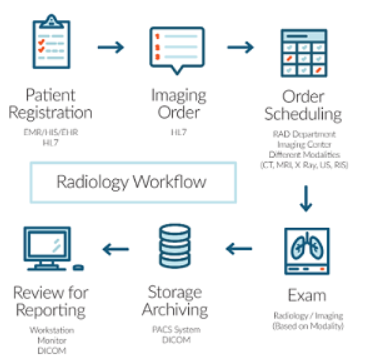

Reference - [https://towardsdatascience.com/understanding-dicoms-835cd2e57d0b](https://towardsdatascience.com/understanding-dicoms-835cd2e57d0b)

In [ ]:
files = folders = 0

path = "/kaggle/input/osic-pulmonary-fibrosis-progression/train"

for _, dirnames, filenames in os.walk(path):
    files += len(filenames)
    folders += len(dirnames)
print(files,"files/images\n",folders,'folders/patients')

## Examining few DICOM files

In [ ]:
files = glob.glob('../input/osic-pulmonary-fibrosis-progression/train/*/*.dcm')
def dicom_to_image(filename):
    im = dcm.dcmread(filename)
    img = im.pixel_array
    img[img == -2000] = 0
    return img
f, plots = plt.subplots(4, 5, sharex='col', sharey='row', figsize=(10, 8))
for i in range(20):
    plots[i // 5, i % 5].axis('off')
    plots[i // 5, i % 5].imshow(dicom_to_image(files[i]), cmap=plt.cm.bone)

Most of them are similar, let us look randomly again to be sure.

In [ ]:
f, plots = plt.subplots(4, 5, sharex='col', sharey='row', figsize=(10, 8))
for i in range(20):
    plots[i // 5, i % 5].axis('off')
    plots[i // 5, i % 5].imshow(dicom_to_image(np.random.choice(files)), cmap=plt.cm.bone)

So some images are not uniform, again something we will consider during our experiments.

## Dark Images

Thanks to this [discussion](https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/discussion/170861) we are aware the some scans are dark for instance as below.

In [ ]:
files_darkimages = glob.glob('../input/osic-pulmonary-fibrosis-progression/train/ID00105637202208831864134/*.dcm')
print("Patiend files :",len(files_darkimages))
f, plots = plt.subplots(4, 5, sharex='col', sharey='row', figsize=(10, 8))
for i in range(20):
    plots[i // 5, i % 5].axis('off')
    plots[i // 5, i % 5].imshow(dicom_to_image(files_darkimages[i]), cmap=plt.cm.bone)

## Dark images - fixed

There seems two ways to fix this as mentioned [here](http://uwmsk.org/jupyter/Jupyter_DICOM_toolbox.html)

1. `equalize_hist`
2. `equalize_adapthist`

Let us try both of these

In [ ]:
from skimage import exposure
def dicom_to_image2(filename):
    im = dcm.dcmread(filename)
    img = im.pixel_array
    img = exposure.equalize_hist(img)
    return img

def dicom_to_image3(filename):
    im = dcm.dcmread(filename)
    img = im.pixel_array
    img = exposure.equalize_adapthist(img)
    return img

In [ ]:
f, plots = plt.subplots(4, 5, sharex='col', sharey='row', figsize=(10, 8))
for i in range(20):
    plots[i // 5, i % 5].axis('off')
    plots[i // 5, i % 5].imshow(dicom_to_image2(files_darkimages[i]), cmap=plt.cm.bone)
plt.title("Dark images fixed using equalize_hist")

In [ ]:
f, plots = plt.subplots(4, 5, sharex='col', sharey='row', figsize=(10, 8))
for i in range(20):
    plots[i // 5, i % 5].axis('off')
    plots[i // 5, i % 5].imshow(dicom_to_image3(files_darkimages[i]), cmap=plt.cm.bone)
plt.title("Dark images fixed using equalize_adapthist")

While the images with equalise_hist are more clear, it is not recommended over the other. Hence let us leave both these options for our experiments during training.

Let us view the initial images again with the new methods.

In [ ]:
f, plots = plt.subplots(4, 5, sharex='col', sharey='row', figsize=(10, 8))
for i in range(20):
    plots[i // 5, i % 5].axis('off')
    plots[i // 5, i % 5].imshow(dicom_to_image2(files[i]), cmap=plt.cm.bone)
plt.title("Dark images fixed using equalize_hist")

In [ ]:
f, plots = plt.subplots(4, 5, sharex='col', sharey='row', figsize=(10, 8))
for i in range(20):
    plots[i // 5, i % 5].axis('off')
    plots[i // 5, i % 5].imshow(dicom_to_image3(files[i]), cmap=plt.cm.bone)
plt.title("Dark images fixed using equalize_adapthist")

# Pytorch Neural Network

This code has been built upon https://www.kaggle.com/carlossouza/quantile-regression-pytorch-tabular-data-only

We are only using Tabular Data at the moment.

## Additional libraries for Training

In [ ]:
import copy
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import GroupKFold
from torch.utils.data import Dataset
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import trange
from time import time

## Inputs for Neural Network

In [ ]:
root_dir = Path('/kaggle/input/osic-pulmonary-fibrosis-progression')
model_dir = '/kaggle/working/model_states'
num_kfolds = 5
batch_size = 32
learning_rate = 3e-3
num_epochs = 1000
es_patience = 8
quantiles = (0.2, 0.5, 0.8)
model_name ='descartes'
tensorboard_dir = Path('/kaggle/working/runs')

## Dataset Initialization

In [ ]:
class ClinicalDataset(Dataset):
    def __init__(self, root_dir, mode, transform=None):
        self.transform = transform
        self.mode = mode

        tr = pd.read_csv(Path(root_dir)/"train.csv")
        tr.drop_duplicates(keep=False, inplace=True, subset=['Patient', 'Weeks'])
        chunk = pd.read_csv(Path(root_dir)/"test.csv")

        sub = pd.read_csv(Path(root_dir)/"sample_submission.csv")
        sub['Patient'] = sub['Patient_Week'].apply(lambda x: x.split('_')[0])
        sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
        sub = sub[['Patient', 'Weeks', 'Confidence', 'Patient_Week']]
        sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")

        tr['WHERE'] = 'train'
        chunk['WHERE'] = 'val'
        sub['WHERE'] = 'test'
        data = tr.append([chunk, sub])

        data['min_week'] = data['Weeks']
        data.loc[data.WHERE == 'test', 'min_week'] = np.nan
        data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

        base = data.loc[data.Weeks == data.min_week]
        base = base[['Patient', 'FVC']].copy()
        base.columns = ['Patient', 'min_FVC']
        base['nb'] = 1
        base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
        base = base[base.nb == 1]
        base.drop('nb', axis=1, inplace=True)

        data = data.merge(base, on='Patient', how='left')
        data['base_week'] = data['Weeks'] - data['min_week']
        del base

        COLS = ['Sex', 'SmokingStatus']
        self.FE = []
        for col in COLS:
            for mod in data[col].unique():
                self.FE.append(mod)
                data[mod] = (data[col] == mod).astype(int)

        data['age'] = (data['Age'] - data['Age'].min()) / \
                      (data['Age'].max() - data['Age'].min())
        data['BASE'] = (data['min_FVC'] - data['min_FVC'].min()) / \
                       (data['min_FVC'].max() - data['min_FVC'].min())
        data['week'] = (data['base_week'] - data['base_week'].min()) / \
                       (data['base_week'].max() - data['base_week'].min())
        data['percent'] = (data['Percent'] - data['Percent'].min()) / \
                          (data['Percent'].max() - data['Percent'].min())
        self.FE += ['age', 'percent', 'week', 'BASE']

        self.raw = data.loc[data.WHERE == mode].reset_index()
        del data

    def __len__(self):
        return len(self.raw)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = {
            'patient_id': self.raw['Patient'].iloc[idx],
            'features': self.raw[self.FE].iloc[idx].values,
            'target': self.raw['FVC'].iloc[idx]
        }
        if self.transform:
            sample = self.transform(sample)

        return sample

    def group_kfold(self, n_splits):
        gkf = GroupKFold(n_splits=n_splits)
        groups = self.raw['Patient']
        for train_idx, val_idx in gkf.split(self.raw, self.raw, groups):
            train = Subset(self, train_idx)
            val = Subset(self, val_idx)
            yield train, val

    def group_split(self, test_size=0.2):
        """To test no-kfold
        """
        gss = GroupShuffleSplit(n_splits=1, test_size=test_size)
        groups = self.raw['Patient']
        idx = list(gss.split(self.raw, self.raw, groups))
        train = Subset(self, idx[0][0])
        val = Subset(self, idx[0][1])
        return train, val

## Neural Network

In [ ]:
class QuantModel(nn.Module):
    def __init__(self, in_tabular_features=9, out_quantiles=3):
        super(QuantModel, self).__init__()
        self.fc1 = nn.Linear(in_tabular_features, 100)
        #self.bn1 = nn.BatchNorm1d(num_features=100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, out_quantiles)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        #x = self.bn1(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x


def quantile_loss(preds, target, quantiles):
    #assert not target.requires_grad
    assert len(preds) == len(target)
    losses = []
    for i, q in enumerate(quantiles):
        errors = target - preds[:, i]
        losses.append(torch.max((q - 1) * errors, q * errors).unsqueeze(1))
    loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
    return loss

def metric_loss(pred_fvc,true_fvc):
        #Implementation of the metric in pytorch
    sigma = pred_fvc[:, 2] - pred_fvc[:, 0]
    true_fvc=torch.reshape(true_fvc,pred_fvc[:,1].shape)
    sigma_clipped=torch.clamp(sigma,min=70)
    delta=torch.clamp(torch.abs(pred_fvc[:,1]-true_fvc),max=1000)
    metric=torch.div(-torch.sqrt(torch.tensor([2.0]).to(device))*delta,sigma_clipped)-torch.log(torch.sqrt(torch.tensor([2.0]).to(device))*sigma_clipped)
    return metric


# Training

We are using EarlyStopping. I implement this almost everywhere as it is very easy to implement i.e. hold a copy of weights when validation LLL (or accuracy or f1) increases and at the end of the training use the best weights. A easy powerful way to prevent overfitting.

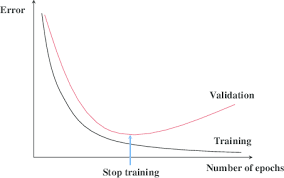

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:

models = []

train_loss = []
val_lll = []
# Load the data
data = ClinicalDataset(root_dir=root_dir, mode='train')
folds = data.group_kfold(num_kfolds)
#t0 = time()
#if len(testfiles) == 5:
    #f= open("/kaggle/working/training.log","w+") 
for fold, (trainset, valset) in enumerate(folds):
    best_val = None
    patience = es_patience
    model = QuantModel().to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = Adam(params, lr=learning_rate)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    lr_scheduler = StepLR(optimizer, step_size=20, gamma=0.5)


    print("=="*20+"Fold "+str(fold+1)+"=="*20)
    Path(model_dir).mkdir(parents=True, exist_ok=True)
    model_path = model_dir+f'/fold_{fold}.pth'
    now = datetime.now()
    dataset_sizes = {'train': len(trainset), 'val': len(valset)}
    dataloaders = {
            'train': DataLoader(trainset, batch_size=batch_size,
                                shuffle=True, num_workers=2),
            'val': DataLoader(valset, batch_size=batch_size,
                              shuffle=False, num_workers=2)
    }
    train_loss_epoch = []
    val_lll_epoch = []
    for epoch in range(num_epochs):
        start_time = time()
        itr = 1
        model.train()
        train_losses =[]
        for batch in dataloaders['train']:
            inputs = batch['features'].float().to(device)
            targets = batch['target'].to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                preds = model(inputs)
                loss = quantile_loss(preds, targets, quantiles)
                train_losses.append(loss.tolist())
                loss.backward()
                optimizer.step()
           
            if itr % 50 == 0:
                print(f"Epoch #{epoch+1} Iteration #{itr} loss: {loss}")
            itr += 1
            
        model.eval()
        all_preds = []
        all_targets = []
        for batch in dataloaders['val']:
            inputs = batch['features'].float().to(device)
            targets = batch['target']
            optimizer.zero_grad()
            with torch.set_grad_enabled(False):
                preds = model(inputs)
                all_preds.extend(preds.detach().cpu().numpy().tolist())
                all_targets.extend(targets.numpy().tolist()) # np.append(an_array, row_to_append, 0)
        all_preds =torch.FloatTensor(all_preds)
        all_targets =torch.FloatTensor(all_targets)
        val_metric_loss = metric_loss(all_preds, all_targets)
        val_metric_loss = torch.mean(val_metric_loss).tolist()

        lr_scheduler.step()
        print(f"Epoch #{epoch+1}","Training loss : {0:.4f}".format(np.mean(train_losses)),"Validation LLL : {0:.4f}".format(val_metric_loss),"Time taken :",str(timedelta(seconds=time() - start_time))[:7])
        train_loss_epoch.append(np.mean(train_losses))
        val_lll_epoch.append(val_metric_loss)
        if not best_val:
            best_val = val_metric_loss  # So any validation roc_auc we have is the best one for now
            print("Info : Saving model")
            torch.save(copy.deepcopy(model.state_dict()), model_path)  # Saving the model
        if val_metric_loss > best_val:
            print("Info : Saving model as Laplace Log Likelihood is increased from {0:.4f}".format(best_val),"to {0:.4f}".format(val_metric_loss))
            best_val = val_metric_loss
            patience = es_patience  # Resetting patience since we have new best validation accuracy
            torch.save(copy.deepcopy(model.state_dict()), model_path)  # Saving current best model torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')
        else:
            patience -= 1
            if patience == 0:
                print('Early stopping. Best Validation Laplace Log Likelihood: {:.3f}'.format(best_val))
                break
    model.load_state_dict(torch.load(model_path))
    models.append(model)
    train_loss.append(train_loss_epoch)
    val_lll.append(val_lll_epoch)
print('Finished Training of BiLSTM Model')

# Training visualisations

In [ ]:
plt.figure(figsize=(15,4))
for i in range(len(train_loss)):
    plt.plot(train_loss[i],label="Fold "+str(i+1))
#plt.plot(val_loss,label="Validation loss",color="blue")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Epoch vs Training Loss")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(15,4))
for i in range(len(val_lll)):
    plt.plot(val_lll[i],label="Fold "+str(i+1))
plt.xlabel("Epoch")
plt.ylabel("Validation Log Laplacian Likelihood")
plt.title("Epoch vs Validation Log Laplacian Likelihood")
plt.legend()
plt.grid()
plt.show()

These graphs say that a maximum of 20 epochs for every fold is good enough.

## Test predicition

In [ ]:
data = ClinicalDataset(root_dir, mode='test')
avg_preds = np.zeros((len(data), len(quantiles)))

for model in models:
    dataloader = DataLoader(data, batch_size=batch_size,
                            shuffle=False, num_workers=2)
    preds = []
    for batch in dataloader:
        inputs = batch['features'].float()
        with torch.no_grad():
            x = model(inputs)
            preds.append(x)

    preds = torch.cat(preds, dim=0).numpy()
    avg_preds += preds

avg_preds /= len(models)
df = pd.DataFrame(data=avg_preds, columns=list(quantiles))
df['Patient_Week'] = data.raw['Patient_Week']
df['FVC'] = df[quantiles[1]]
df['Confidence'] = df[quantiles[2]] - df[quantiles[0]]
df = df.drop(columns=list(quantiles))
df.to_csv('submission.csv', index=False)

In [ ]:
df.head()

I will continue to work on it to the best of my ability.